<a href="https://colab.research.google.com/github/shashwatsaket46/study/blob/main/lab3_regularization_logreg_gd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

## Part 1: LASSO and Gradient Descent

In this part of the lab, we will implement L1-regularized linear regression and solve it using gradient descent. First, let us generate the data. We will apply `StandardScaler()` to the input features to make sure they are normalized which will make optimization easier.

Dataset shape: X_tr=(400, 10), y_tr=(400,), X_te=(100, 10), y_te=(100,)


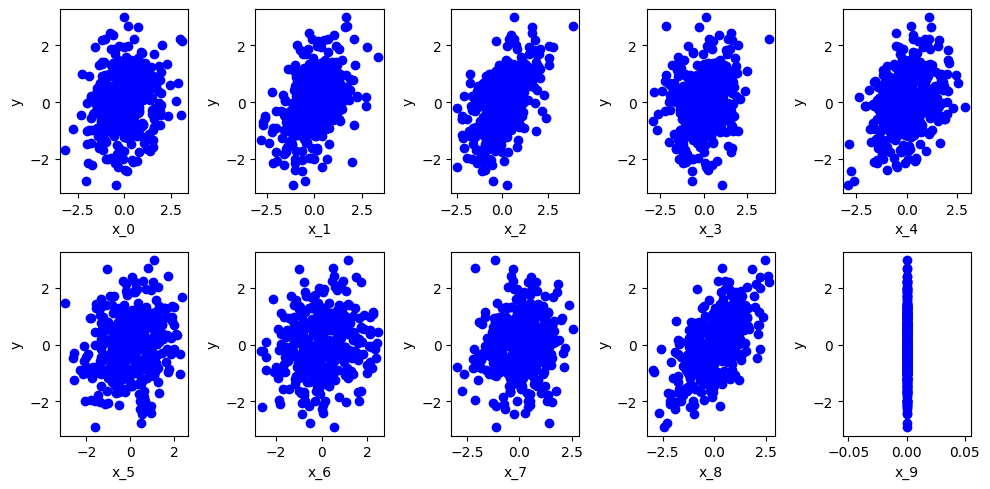

In [4]:
n_data = 500
n_train = 400
n_test = n_data - n_train
n_features = 10

X, y = make_regression(n_samples=n_data, n_features=n_features-1, noise=1, random_state=42)
X = np.concat([X, np.ones((n_data, 1))], axis=1)
X = StandardScaler().fit_transform(X)
y -= y.mean()
y = y / np.std(y)
y = y.reshape(-1)


X_tr, X_te = X[:n_train], X[n_train:]
y_tr, y_te = y[:n_train], y[n_train:]

f, arr = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
  arr[i // 5, i % 5].plot(X_tr[:, i], y_tr, "bo")
  arr[i // 5, i % 5].set_xlabel(f"x_{i}")
  arr[i // 5, i % 5].set_ylabel("y")


plt.tight_layout()
print(f"Dataset shape: X_tr={X_tr.shape}, y_tr={y_tr.shape}, X_te={X_te.shape}, y_te={y_te.shape}")

Recall that in $L_1$-regularized linear regression, the model predictions are given by
$$
\hat y = x^T w,
$$
where $\hat y \in \mathbb R$, $w \in \mathbb R^d$ and $x \in \mathbb R^d$. The loss is given by
$$
L(w) = \frac 1 n \|y - X w\|^2 + \lambda \|w\|_1,
$$
where $n$ is the number of datapoints, $y \in \mathbb R^n$, $X \in \mathbb R^{n \times d}$. Now, let us implement the loss in numpy.

Complete the function below. The loss you should get is approximately 6.

In [11]:

def compute_loss(X, y, w, lam):
    """
    Compute the total loss for L1-regularized linear regression.

    Parameters:
    -----------
    X : numpy.ndarray of shape (n, d)
        Feature matrix where n is number samples and d is number of features
    y : numpy.ndarray of shape (n,)
        Target values
    w : numpy.ndarray of shape (d,)
        Weight vector
    lam : float
        L1 regularization strength lambda (scalar)

    Returns:
    --------
    loss: float
        Combined MSE and L1 penalty, scalar
    """
    # Here we need to get two different scalar, first is the Mean Squarred error and the other is the L1 penalty.

    n = X.shape[0]
    y_predicted = (w.reshape(1, -1) @ X.T).flatten()
    # Here we can calculate the y_predicted using X @ w as well.
    mean_squarred_error = (1/n)*np.sum((y-y_predicted)**2)
    l1_penalty = lam*np.sum(np.abs(w))
    loss = mean_squarred_error +l1_penalty

    return loss

lam = 0.1
w = np.ones((n_features,))
compute_loss(X_tr, y_tr, w, lam)

np.float64(5.934029543783646)

So, here we got the loss = 5.93 which is approximately 6, so I am moving forward.

We want to minimize this loss using gradient descent. The next step is to derive and implement the gradient of the loss: $\nabla_w L(w)$.

**Hint**: check the derivation of the gradient for the l2-regularized linear regression as we did in lecture 3 (slide 24 [here](https://docs.google.com/presentation/d/1_HRFPT9uRl8deCtj-DF1eNX_luFXmr2asUnHaBzf5MQ/edit?usp=sharing)). Be careful with the normalization: in the lecture we did not have the $\frac 1 n$ scaling factor for the data fit term $\|Xw - y\|^2$!

Use the identities
- $\frac{\partial}{\partial w}(w^TAw) = 2Aw$ for symmetric matrix $A$
- $\frac{\partial}{\partial w}(a^Tw) = a$ for vector $a$

**Hint**: The l1-regularization term is non-smooth when some of the components of $w$ are 0, you can assume that all components are non-zero here. You may get intuition for what the gradient will look by studying the derivative $\frac{d|u|}{du}$ for one-dimensional $u \in \mathbb R$.

In [13]:
def compute_gradient(X, y, w, lam):
    """
    Compute gradient of L1-regularized linear regression loss.

    Parameters:
    -----------
    X : numpy.ndarray of shape (n, d)
        Feature matrix where n is number samples and d is number of features
    y : numpy.ndarray of shape (n,)
        Target values
    w : numpy.ndarray of shape (d,)
        Weight vector
    lam : float
        L1 regularization strength lambda (scalar)

    Returns:
    --------
    gradient : numpy.ndarray of shape (d,)
        Gradient of the loss function with respect to w
    """
    # TODO: YOUR CODE HERE!
    n =X.shape[0]
    y_predicted =X@w
    gradient_data = (2.0/n) * (X.T@(y_predicted-y))
    l1_term = lam*np.sign(w)
    gradient = gradient_data +l1_term
    return gradient


w = np.random.randn(n_features,)
compute_gradient(X_tr, y_tr, w, lam)

array([-1.03869741, -1.4807184 , -0.36238247, -4.57215333, -4.07597623,
       -1.86414732, -2.92957766, -0.16976797, -3.44398706, -0.1       ])

We can check the implementation of the gradient numerically by comparing it to a finite difference approximation. Run the code below. If you implemented both the loss and the gradient correctly, you should get a small number below $10^{-6}$.

In [14]:
from scipy.optimize import check_grad

lam = 0.1
w0 = np.random.randn(n_features,)

def f(w):
  return compute_loss(X_tr, y_tr, w, lam)

def g(w):
  return compute_gradient(X_tr, y_tr, w, lam)

print(check_grad(f, g, w0))

1.4522555158640903e-07


Now that we computed the gradient, we can do gradient descent! Recall that the update rule is given by:
$$w_{k+1} = w_k - \alpha \nabla_w L(w_k).$$

Please implement gradient descent by completing the function below. Make use of the functions `compute_gradient` and `compute_loss` that you implemented above.

Along with the final value of w, return the list of values of the loss $L(w_k)$ for each iteration $k$.

Text(0, 0.5, 'Loss')

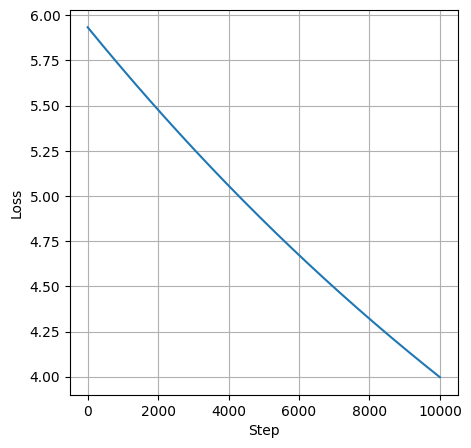

In [22]:
def gradient_descent(X, y, w_init, lam, alpha, num_iter=10000
                     ):
    """
    Compute gradient of L1-regularized linear regression loss.

    Parameters:
    -----------
    X : numpy.ndarray of shape (n, d)
        Feature matrix where n is number samples and d is number of features
    y : numpy.ndarray of shape (n,)
        Target values
    w_init : numpy.ndarray of shape (d,)
        Initial weight vector
    lam : float
        L1 regularization strength lambda
    num_iter: int
      number of iterations of gradient decent to run

    Returns:
    --------
    w_final : numpy.ndarray of shape (d,)
        Final value of parameters w
    loss_history: list[float]
        List of loss values at each iteration
    """

    # Initialize weights and loss history
    w = w_init.copy()  # Make a copy to avoid modifying the input
    loss_history = []

    # Perform gradient descent
    for i in range(num_iter):
      loss_history.append(compute_loss(X,y,w,lam))
      w-= alpha *(compute_gradient(X,y,w,lam))
    return w, loss_history


w_init = np.ones((n_features,))
w, loss_history = gradient_descent(X_tr, y_tr, w_init, lam=0.1, alpha=.00001)

f, ax = plt.subplots(1, 1, figsize=(5, 5))
xs = np.arange(len(loss_history))
ys = np.array(loss_history)

ax.plot(xs, ys)
ax.grid()
ax.set_xlabel("Step")
ax.set_ylabel("Loss")


Run gradient descent with different learning rates. Add your code for these experiments below.

Explain the results: write a couple of sentences on what do you see depending on the different learning rate and why.

**Add your explanaiton here:** Here I am seeing that when I am increasing the learning rate (alpha) like 0.1, then we see a sharp drop in the loss with respect to the step like it . When I am decreasing the alpha, lets say 0.01, we see a smoother concave curve of loss vs step. When we further decrease the alpha, lets say 0.0001, we see a linear curve which is learning very slow with respect to number of steps it is taking.

Recall that l1 linear regression will set some of the parameters of w to zero. Let's see how many parameters will be set to zero as a function of regularization strength. Run the cell below.

Text(0, 0.5, 'number of zeros in w*')

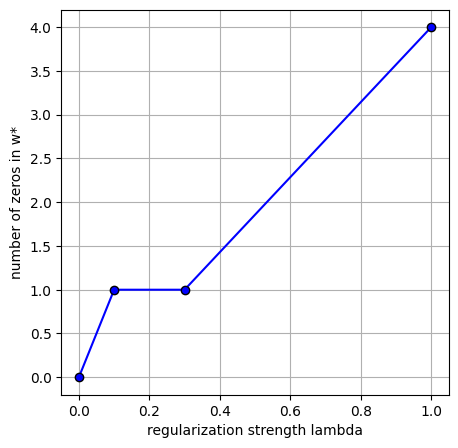

In [23]:
lambdas = [0., 1e-1, 3e-1, 1]
num_zeros = []

for lam in lambdas:
  w_init = np.ones((n_features,))
  w, loss_history = gradient_descent(X_tr, y_tr, w_init, lam=lam, alpha=.1, num_iter=1000)
  num_zeros.append(np.sum(w < 1.e-6))



f, ax = plt.subplots(1, 1, figsize=(5, 5))
xs = lambdas
ys = num_zeros

ax.plot(xs, ys, "-bo", mec="k")
ax.grid()
ax.set_xlabel("regularization strength lambda")
ax.set_ylabel("number of zeros in w*")

Explain the results: write a couple of sentences on what do you see depending on the different value of $\lambda$ and why.

**Add your explanaiton here:**

## Part 2: Logistic Regression via Stochastic Gradient Descent

This part of the lab demonstrates multi-class logistic regression (softmax regression) using PyTorch.
We'll classify handwritten digits from the MNIST dataset using a linear model with
L2 regularization and analyze the impact of regularization strength on model performance.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

First, let's load the data. In pytorch, we will use [DataLoader](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html) objects which allow us to iterate over the dataset producing batches of training examples instead of working with the full dataset directly. This will make it convenient to implement SGD.

Read the code below carefully and make sure you understand it.

In [ ]:
def load_mnist_data(batch_size=64):
    """
    Load and preprocess MNIST dataset.

    MNIST contains 28x28 grayscale images of handwritten digits (0-9).
    We'll flatten the images to 784-dimensional vectors for logistic regression.

    Args:
        batch_size (int): Number of samples per batch

    Returns:
        train_loader, test_loader: DataLoader objects for training and testing
    """

    # Define transformations: convert to tensor and normalize
    # Normalization helps with gradient descent convergence
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert PIL image to tensor and scale to [0,1]
        transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST mean and std
    ])

    # Load training dataset
    train_dataset = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    # Load test dataset
    test_dataset = datasets.MNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    # Create data loaders for batch processing
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True  # Shuffle training data for better SGD performance
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle test data
    )

    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Batch size: {batch_size}")

    return train_loader, test_loader


train_loader, test_loader = load_mnist_data()

Let's load the first batch and look at the shapes of the data it returns.

In [ ]:
batch = next(iter(train_loader))
x, y = batch
print(f"{x.shape=}, {y.shape=}")
print(f"{len(train_loader)=}")

When we will iterate over the `train_loader`, each iteration will return a batch containing 64 images of shape `1x28x28` and the corresponding labels. The number of batches in the iterator is `60000 / 64 = 938` (where we round the division up). Let's look at the data.

In [ ]:
def visualize_mnist_samples(train_loader, num_samples=16):
    """
    Visualize random samples from the MNIST dataset.

    This function helps students understand what the input data looks like
    before it gets flattened and fed into the logistic regression model.

    Args:
        train_loader: DataLoader for training data
        num_samples: Number of samples to display (should be a perfect square)
    """
    # Get a batch of data
    data_iter = iter(train_loader)
    images, labels = next(data_iter)

    # Create subplot grid
    rows = int(np.sqrt(num_samples))
    cols = rows

    plt.figure(figsize=(12, 12))
    plt.suptitle('MNIST Dataset Samples', fontsize=16, fontweight='bold')

    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)

        # Convert tensor to numpy and remove channel dimension
        # Shape: (1, 28, 28) -> (28, 28)
        img = images[i].squeeze().numpy()

        # Display image
        plt.imshow(img, cmap='gray')
        plt.title(f'Label: {labels[i].item()}', fontsize=12)
        plt.axis('off')  # Remove axis ticks and labels

    plt.tight_layout()
    plt.show()

    print(f"Image shape: {images[0].shape}")
    print(f"After flattening: {images[0].view(-1).shape}")
    print(f"Data type: {images[0].dtype}")
    print(f"Value range: [{images[0].min().item():.3f}, {images[0].max().item():.3f}]")

visualize_mnist_samples(train_loader)

Now, let us implement the logistic regression model as a `torch.nn.Module`. Carefully study the implementation below and make sure you understand how it works and what each line is doing.

In [ ]:
class LogisticRegression(nn.Module):
    """
    Multi-class Logistic Regression (Softmax Regression) model.

    This is a linear classifier that maps input features directly to class logits.
    The softmax function converts logits to probabilities for multi-class classification.

    Architecture: Input (784) -> Linear -> Output (10 classes)
    """

    def __init__(self, input_dim=784, num_classes=10):
        """
        Initialize the logistic regression model.

        Args:
            input_dim (int): Number of input features (784 for flattened 28x28 images)
            num_classes (int): Number of output classes (10 for digits 0-9)
        """
        super(LogisticRegression, self).__init__()

        # Single linear layer: y = Wx + b
        # This maps from 784-dimensional input to 10-dimensional output (logits)
        self.linear = nn.Linear(input_dim, num_classes)

        # Initialize weights with small random values
        # Good initialization is important for gradient descent convergence
        nn.init.normal_(self.linear.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)

        Returns:
            torch.Tensor: Raw logits of shape (batch_size, num_classes)
        """
        # Flatten the input images: (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(x.size(0), -1)

        # Apply linear transformation to get logits
        logits = self.linear(x)

        return logits

The magic of PyTorch is that it allows us to compute gradients automatically! Consider the example below.

Here, we use PyTorch to automatically compute the gradients of the quadratic form $w^T A w$. We derived it in the lecture, it took a bit of work. Now, we can compute the gradients with a few lines of code!

In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Create a 3D vector w with gradient tracking enabled
w = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

# Create a random 3x3 matrix and make it symmetric
A_random = torch.randn(3, 3)
A = (A_random + A_random.T) / 2  # Make symmetric: A = (A + A^T) / 2

print("Vector w:")
print(w)
print("\nSymmetric matrix A:")
print(A)

# Compute the quadratic form: loss = w^T A w
loss = torch.matmul(torch.matmul(w.T, A), w)

print(f"\nQuadratic form w^T A w = {loss.item():.4f}")

# Compute gradients using backpropagation
loss.backward()

# Access the computed gradient
print(f"\nGradient ∇_w(w^T A w):")
print(w.grad)

# Verify manually: gradient of w^T A w is (A + A^T) w = 2Aw (since A is symmetric)
expected_grad = 2 * torch.matmul(A, w.detach())
print(f"\nExpected gradient (2Aw):")
print(expected_grad)

print(f"\nGradients match: {torch.allclose(w.grad, expected_grad)}")

Now, let us implement L2-regularized logistic regression loss.

In [ ]:
def l2_regularized_cross_entropy_loss(logits, targets, model, lambda_reg=0.01):
    """
    Compute cross-entropy loss with L2 regularization.

    This function combines the standard cross-entropy loss with an L2 penalty
    on the model weights to prevent overfitting. The total loss is:

    Loss = CrossEntropy(logits, targets) + λ * ||W||²

    where λ (lambda_reg) controls the strength of regularization.

    Args:
        logits (torch.Tensor): Raw model outputs (before softmax), shape (batch_size, num_classes)
        targets (torch.Tensor): True class labels, shape (batch_size,)
        model (nn.Module): The model (needed to access weights for regularization)
        lambda_reg (float): L2 regularization strength

    Returns:
        total_loss: Combined loss used for backpropagation
    """
    # Compute standard cross-entropy loss
    # F.cross_entropy applies softmax internally and computes negative log-likelihood
    ce_loss = F.cross_entropy(logits, targets)

    # Compute L2 regularization penalty
    # Sum of squares of all model parameters (weights and biases)
    l2_penalty = torch.sum(model.linear.weight**2)

    # Combine cross-entropy loss with L2 penalty
    total_loss = ce_loss + lambda_reg * l2_penalty

    return total_loss


model = LogisticRegression()
data, targets = next(iter(train_loader))

# Forward pass
logits = model(data)

# Compute loss (including L2 regularization)
loss = l2_regularized_cross_entropy_loss(logits, targets, model)

Print out the gradient of the loss we computed above on the given batch of data with respect to weights and biases of the model.

In [ ]:
# compute the loss...
# TODO: Your code goes here!

Now, let's train the model! We will use the SGD implementation from pytorch. Read the following code carefully and make sure you understand it: it will be very relevant when we start training neural networks!

In [ ]:
def train_model(model, train_loader, lambda_reg=0.01, learning_rate=0.01, num_epochs=10):
    """
    Train the logistic regression model using SGD with L2 regularization.

    Args:
        model: The neural network model
        train_loader: DataLoader for training data
        device: Device to run computations on
        lambda_reg: L2 regularization strength
        learning_rate: Learning rate for SGD
        num_epochs: Number of training epochs

    Returns:
        lists of training losses per epoch
    """
    model.train()  # Set model to training mode

    # Create optimizer (SGD with momentum for better convergence)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    train_losses = []
    train_accuracies = []

    print("Starting training...")
    print("-" * 50)

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for batch_idx, (data, targets) in enumerate(train_loader):

            # Forward pass
            logits = model(data)

            # Compute loss using our custom function
            total_loss = l2_regularized_cross_entropy_loss(
                logits, targets, model, lambda_reg
            )

            # Backward pass
            optimizer.zero_grad()  # Clear gradients from previous step
            total_loss.backward()   # Compute gradients
            optimizer.step()       # Update parameters

            # Accumulate statistics
            epoch_loss += total_loss.item()
            train_losses.append(total_loss.item())

            # Print progress every 200 batches
            if batch_idx % 200 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, '
                      f'Loss: {total_loss.item():.4f}')

        # Calculate epoch statistics
        avg_loss = epoch_loss / len(train_loader)

        print(f'Epoch {epoch+1}/{num_epochs}: Avg Loss = {avg_loss:.4f}')

    print("-" * 50)
    print("Training completed!")

    return train_losses


model = LogisticRegression()
train_losses = train_model(model, train_loader, lambda_reg=0.01, learning_rate=0.001, num_epochs=2)

plt.plot(train_losses)
plt.xlabel("batches")
plt.ylabel("loss")

Now, let us evaluate the model that we trained! You will need to fist compute the predictions on each datapoint in the `test_loader` and store them in a numpy array. Make use of `model.forward` to compute the logits, and then convert them to predictions. You will also need to return the true class labels for all of the test examples.

In [ ]:
def evaluate_predictions_labels(model, test_loader):
    """
    Returns model predictions and true labels on the given dataloader.

    Args:
        model: Trained neural network model
        test_loader: DataLoader for test data

    Returns:
        all_predictions: numpy array of shape (n_test_data,), all test predictions
        all_targets: numpy array of shape (n_test_data,), all test ground truth labels
    """
    model.eval()  # Set model to evaluation mode (disables dropout, etc.)

    all_predictions = []
    all_targets = []

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for data, targets in test_loader:
            # TODO: Your code goes here!
            ...

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    return all_predictions, all_targets

all_predictions, all_targets = evaluate_predictions_labels(model, test_loader)
print(f"{all_predictions.shape=}, {all_targets.shape=}")
print(f"{all_predictions.shape=}, {all_targets.shape=}")

Now, let's implement the accuracy metric for this model.

In [ ]:
def accuracy(all_predictions, all_targets):
  # TODO: Your code goes here!
  ...

accuracy(all_predictions, all_targets)

We now got our first MNIST classifier! You should see an accuracy around 85-90%.

Now, experiment with the L2 regularization parameter in the model. What happens to accuracy if you set the regularization strength to 10? What if you set it to 0?

Provide your code and write a couple of sentences explaining the results.